In [30]:
import numpy as np
import pandas as pd

df=pd.read_csv('Creditcard_data.csv')
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (772, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,1
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [31]:
target_candidates = ["Class","class","target","Target","label","Label"]
target_col = None
for c in target_candidates:
    if c in df.columns:
        target_col = c
        break
if target_col is None:
    target_col = df.columns[-1]
print("Target column:", target_col)
print("\nOriginal class distribution:")
print(df[target_col].value_counts())

Target column: Class

Original class distribution:
Class
0    763
1      9
Name: count, dtype: int64


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
SEED = 42
np.random.seed(SEED)

counts = df[target_col].value_counts()
minority_class = counts.idxmin()
majority_class = counts.idxmax()
n_min = counts.min()
df_min = df[df[target_col] == minority_class]
df_maj = df[df[target_col] == majority_class].sample(n=n_min, random_state=SEED)
df_bal = pd.concat([df_min, df_maj], axis=0).sample(frac=1, random_state=SEED).reset_index(drop=True)
print("Balanced dataset shape:", df_bal.shape)
print("Balanced class distribution:")
print(df_bal[target_col].value_counts())

X_bal = df_bal.drop(columns=[target_col])
y_bal = df_bal[target_col]

Balanced dataset shape: (18, 31)
Balanced class distribution:
Class
1    9
0    9
Name: count, dtype: int64


In [33]:
def samp1_simple_random(df_in, frac=0.80, seed=SEED):
    return df_in.sample(frac=frac, random_state=seed).reset_index(drop=True)

def samp2_systematic(df_in, step=2):
    df_shuf = df_in.sample(frac=1, random_state=SEED).reset_index(drop=True)
    return df_shuf.iloc[::step, :].reset_index(drop=True)

In [34]:
def samp3_stratified_train_part(X, y, keep_frac=0.80, seed=SEED):
    _, X_keep, _, y_keep = train_test_split(
        X, y, test_size=keep_frac, random_state=seed, stratify=y
    )
    return pd.concat([X_keep.reset_index(drop=True), y_keep.reset_index(drop=True)], axis=1)

def samp4_bootstrap(df_in, n=None, seed=SEED):
    if n is None:
        n = len(df_in)
    return df_in.sample(n=n, replace=True, random_state=seed).reset_index(drop=True)

In [35]:
def samp5_cluster(df_in, n_clusters=5, clusters_to_pick=3, seed=SEED):
    df_tmp = df_in.copy()
    first_feat = df_tmp.columns[0]
    df_tmp["_cluster"] = pd.qcut(df_tmp[first_feat], q=n_clusters, labels=False, duplicates="drop")
    rng = np.random.RandomState(seed)
    clusters = df_tmp["_cluster"].dropna().unique()
    pick = rng.choice(clusters, size=min(clusters_to_pick, len(clusters)), replace=False)
    out = df_tmp[df_tmp["_cluster"].isin(pick)].drop(columns=["_cluster"]).reset_index(drop=True)
    return out

In [36]:
df_s1 = samp1_simple_random(df_bal, frac=0.80)
df_s2 = samp2_systematic(df_bal, step=2)
df_s3 = samp3_stratified_train_part(X_bal, y_bal, keep_frac=0.80)
df_s4 = samp4_bootstrap(df_bal, n=len(df_bal))
df_s5 = samp5_cluster(df_bal, n_clusters=5, clusters_to_pick=3)
samples = {
    "Samp1": df_s1,
    "Samp2": df_s2,
    "Samp3": df_s3,
    "Samp4": df_s4,
    "Samp5": df_s5
}
print("Sample sizes + class counts:")
for name, d in samples.items():
    print(f"\n{name} -> shape: {d.shape}")
    print(d[target_col].value_counts())

Sample sizes + class counts:

Samp1 -> shape: (14, 31)
Class
1    8
0    6
Name: count, dtype: int64

Samp2 -> shape: (9, 31)
Class
1    5
0    4
Name: count, dtype: int64

Samp3 -> shape: (15, 31)
Class
0    8
1    7
Name: count, dtype: int64

Samp4 -> shape: (18, 31)
Class
0    12
1     6
Name: count, dtype: int64

Samp5 -> shape: (10, 31)
Class
1    6
0    4
Name: count, dtype: int64


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

models = {
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, random_state=SEED))
    ]),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=SEED, n_jobs=-1),
    "SVM_RBF": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", C=2.0, gamma="scale", random_state=SEED))
    ]),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=7))
    ]),
    "GradientBoosting": GradientBoostingClassifier(random_state=SEED)
}

In [38]:
X_train_base, X_test, y_train_base, y_test = train_test_split(
    X_bal, y_bal, test_size=0.25, random_state=SEED, stratify=y_bal
)
print("\nHoldout test shape:", X_test.shape)
print("Holdout class distribution:", y_test.value_counts().to_dict())

results = pd.DataFrame(index=models.keys(), columns=samples.keys(), dtype=float)

for samp_name, d in samples.items():
    X_s = d.drop(columns=[target_col])
    y_s = d[target_col]

    for model_name, model in models.items():
        model.fit(X_s, y_s)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds) * 100
        results.loc[model_name, samp_name] = acc

results = results.round(2)

print("\nAccuracy: ")
print(results)

best_sampling_per_model = results.idxmax(axis=1)
best_acc_per_model = results.max(axis=1)

summary = pd.DataFrame({
    "Best Sampling Technique": best_sampling_per_model,
    "Best Accuracy (%)": best_acc_per_model
}).sort_values("Best Accuracy (%)", ascending=False)

print("\nBest Model")
print(summary)

best_model, best_sampling = results.stack().idxmax()
best_value = results.stack().max()
print(f"\nBest overall: {best_model} with {best_sampling} => {best_value:.2f}%")



Holdout test shape: (5, 30)
Holdout class distribution: {0: 3, 1: 2}

Accuracy: 
                    Samp1  Samp2  Samp3  Samp4  Samp5
LogisticRegression   80.0   40.0  100.0   40.0   80.0
RandomForest         80.0   80.0  100.0   80.0  100.0
SVM_RBF              80.0   60.0   80.0   60.0   80.0
KNN                  40.0   20.0   60.0   20.0   60.0
GradientBoosting     80.0   80.0  100.0   80.0  100.0

Best Model
                   Best Sampling Technique  Best Accuracy (%)
LogisticRegression                   Samp3              100.0
RandomForest                         Samp3              100.0
GradientBoosting                     Samp3              100.0
SVM_RBF                              Samp1               80.0
KNN                                  Samp3               60.0

Best overall: LogisticRegression with Samp3 => 100.00%


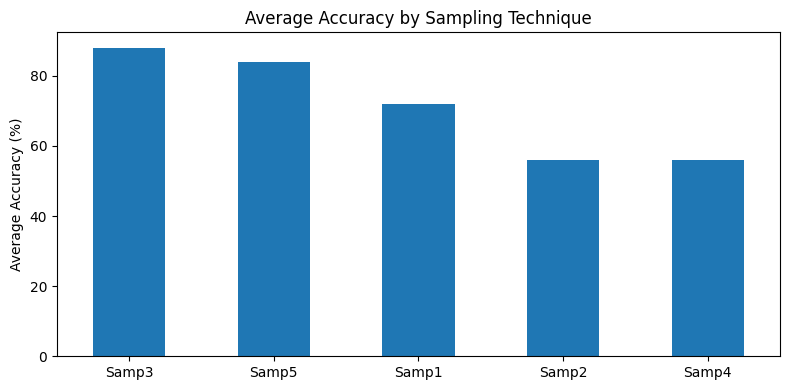

In [40]:
import matplotlib.pyplot as plt

avg_by_sampling = results.mean(axis=0).sort_values(ascending=False)
plt.figure(figsize=(8,4))
avg_by_sampling.plot(kind="bar")
plt.ylabel("Average Accuracy (%)")
plt.title("Average Accuracy by Sampling Technique")
plt.xticks(rotation=0)
plt.tight_layout()

plt.savefig("results_graph.png", dpi=200, bbox_inches="tight")
plt.show()


In [41]:
results.to_csv("accuracy_table.csv", index=True)
summary.to_csv("best_summary.csv", index=True)
print("Saved accuracy_table.csv and best_summary.csv")


Saved accuracy_table.csv and best_summary.csv
